# Adversarial Examples - LeNet on MNIST Data

LeNet style network on the development set of MNIST dataset. 10,000 images.

In [2]:
## Imports
import numpy as np
import pandas as pd

from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import random

import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import transforms
import urllib

plt.rcParams['figure.figsize'] = (20.0, 10.0)

from IPython.display import clear_output

## 1. Load data and model

First we load the model and data.


### 1.1 Model

LeNet

In [3]:
## Load model and data
pretrained_model = "models/lenet_mnist_model.pth"

## Define LeNet model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
## Initialize the network
model = Net()

## Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

## Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### 1.2 Data

Loading the data into a PyTorch dataloader. Here we also integrate the scaling transformation step.

We also define the function `show_tensor_image`to display an image.

In [4]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

In [5]:
def image_to_tensor(data_loader, image_number="random"):
    '''
    Returns a random image of given label as tensor object
    
    Inputs:
    data_loader  -- PyTorch dataloader with the MNIST data
    image_number -- Number of example to show. There are 10,000. Default is random
    
    Returns:
    image        -- Image as tensor of dimension (1, 1, 28, 28)
    label        -- Label as integer
    '''
    
    if image_number == "random":
        i = random.randrange(0, 10000)
    else:
        i = int(image_number)
    
    ## Extract data
    image = data_loader.dataset.data[i,:,:]

    ## Add batch and channel dimension as required by net
    image = image.unsqueeze(0).unsqueeze(0)
    image = image.float()
    
    ## Extract label
    label = int(data_loader.dataset.targets[100].numpy())
       
    ## Print image number
    print("Image number {} chosen\n".format(int(i)))
    
    
    return image, label

In [6]:
def show_tensor_image(tensor):
    '''
    Plots the given image as tensor.
    
    Inputs:
    tensor -- image as tensor of dimension (1, 28, 28)
    
    Returns:
    Plot of the image
    '''
    
    ## Remove batch and channel dimension
    tensor = tensor.detach()
    tensor = tensor.squeeze(0).squeeze(0)

    ## Plot
    plt.imshow(tensor.numpy(), cmap="gray")

## 2. Predict

In [7]:
def predict(model, image, label, return_grad=False, supress_output=True):
    '''
    Predicts
    
    Inputs:
    model          -- net
    image          -- Input image as tensor of shape (1, 1, 28, 28)
    label          -- class label as tensor
    return_grad    -- Returns gradient if set True
    supress_output -- Prints output if set False
    
    Returns:
    gradient       -- None if return_grad=False. Otherwise the gradient from the prediction as a tensor. 
    accuracy       -- Integer of value 1 if class is panda, otherwise 0
    confidence     -- Confidence of prediction
    '''
        
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, torch.tensor([label]))
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
    
    ## Calculate if prediction is correct
    class_index = np.argmax(prediction.detach().numpy())
    
    if class_index == label:
        accuracy = 1.0
        
    else:
        accuracy = 0.0
     
    
    ## Get class index and confidence
    prediction = torch.nn.functional.softmax(prediction[0].detach(), dim=0).numpy()    
    confidence = prediction[class_index] * 100
    
    ## Get class name from the predicted index
    name = np.argmax(prediction)
   
    if supress_output == False:
        print("Predicted class:\n{}\n{:.2f} % confidence\n".format(name, confidence))
        print("Actual class: \n{}".format(label))
    
    return gradient, accuracy, confidence/100

## 3. Generate Adversarial Examples

Functions for generating the examples. The details are discussed in the next section.

In [8]:
def generate_adversarial_fgsm(image, epsilon, grad_x):
    '''
    Applies FGSM attack on input image.
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    ## Compute eta part
    eta = epsilon * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta
    
    ## Clip image to maintain the range [0, 1]
    image_tilde = torch.clamp(image_tilde, 0, 1)
    
    return image_tilde

## 4. Run Attacks

## 4.1 Fast Gradient Sign Method

This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

$\widetilde{x} = x + \eta$

$\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))$

This method computes examples quickly where $\epsilon$ is a hyperparameter. Let's inspect a few clean and perturbed examples for small and large values.

## 4. Run Attacks

## 4.1 Fast Gradient Sign Method

This method by [1] generates adversarial examples quickly. It computes a step of gradient descent

$\widetilde{x} = x + \eta$

$\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))$



In [9]:
def plot_example(image_as_tensor, label, epsilon):
    '''
    Generates an adversarial image. Plots the clean and adversarial image side-by-side
    
    Inputs:
    image_as_tensor -- Image as tensor
    label           -- Class label for target class
    epsilon         -- Hyperparameter for FGSM
    '''
    
    ## Predict for clean image
    gradient, _, _ = predict(model, image_as_tensor, label=label, return_grad=True, supress_output=False)

    print("\n==============================\nPerturbed image: \n")

    ## Compute adversarial image and predict for it.
    perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
    predict(model, perturbed_data, label=label, return_grad=False, supress_output=False)


    ## Plots
    plt.subplot(121)
    plt.title("Clean example", fontsize=30)
    show_tensor_image(image_as_tensor)
    plt.subplot(122)
    plt.title("Adversarial example", fontsize=30)
    show_tensor_image(perturbed_data)

Image number 4362 chosen

Predicted class:
8
100.00 % confidence

Actual class: 
6

Perturbed image: 

Predicted class:
8
94.37 % confidence

Actual class: 
6


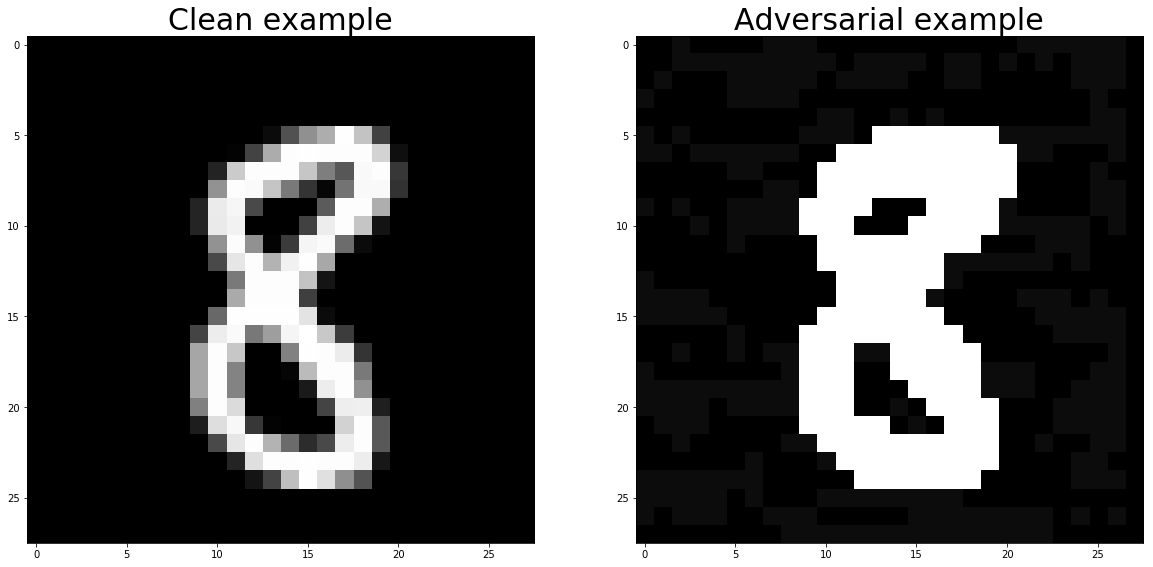

In [10]:
## Random example at lower epsilon
epsilon = 12/255

image_as_tensor, label = image_to_tensor(data_loader)
plot_example(image_as_tensor, label, epsilon)

Image number 5761 chosen

Predicted class:
2
100.00 % confidence

Actual class: 
6

Perturbed image: 

Predicted class:
2
94.82 % confidence

Actual class: 
6


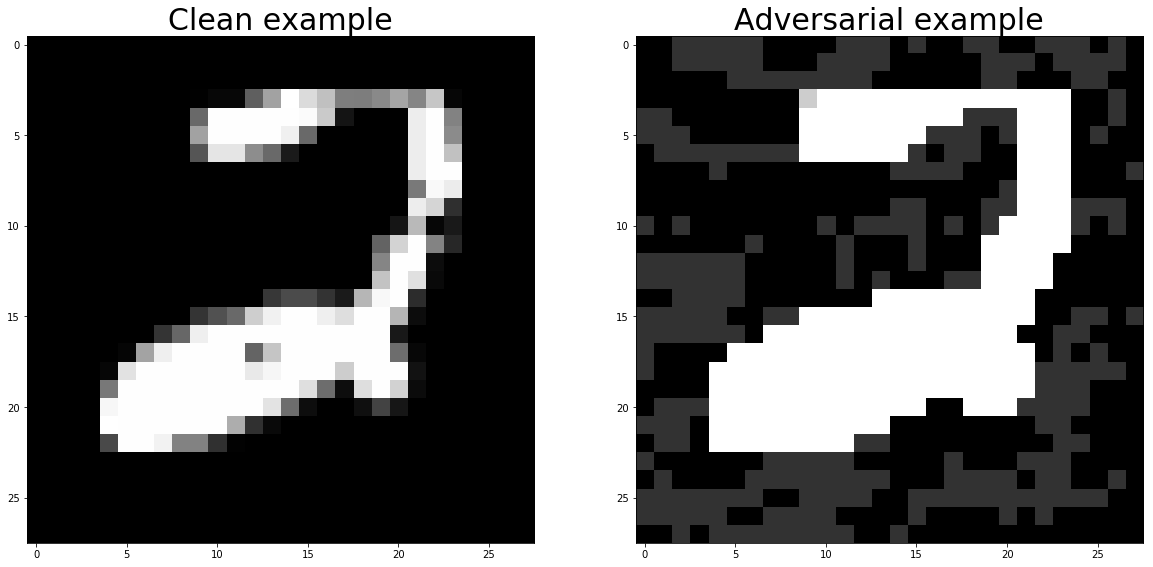

In [12]:
## Random example at higher epsilon
epsilon = 50/255

image_as_tensor, label = image_to_tensor(data_loader, image_number=5761)
plot_example(image_as_tensor, label, epsilon)

As can be seen, for cetrain values of $\epsilon$ the perturbations are clearly visable to the human eye. At the same time, the exampels are still mostly classified as the correct class, however at a lower confidence.

For $\epsilon = 50/255$ sample number `5761` is an example for a desirable adversarial input. The predicted class is `2` with a confidence of over $96$%. However, the actual class is `9`.

Next we generate adversarial inputs with different values of $\epsilon$ and compute the average accuracy and confidence on all data.

In [13]:
## Run on all 10000 examples
epsilons = [0, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
   
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print(i)
        
        ## Predict with clean image
        gradient, acc, conf = predict(model, image_as_tensor, label=label, return_grad=True)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
        _, acc, conf = predict(model, perturbed_data, label=label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1
        
    ## Add accuracies and confidences
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
result.to_csv("results/LeNet_MNIST_FGSM.csv")

Running for epsilon 0.35
10000


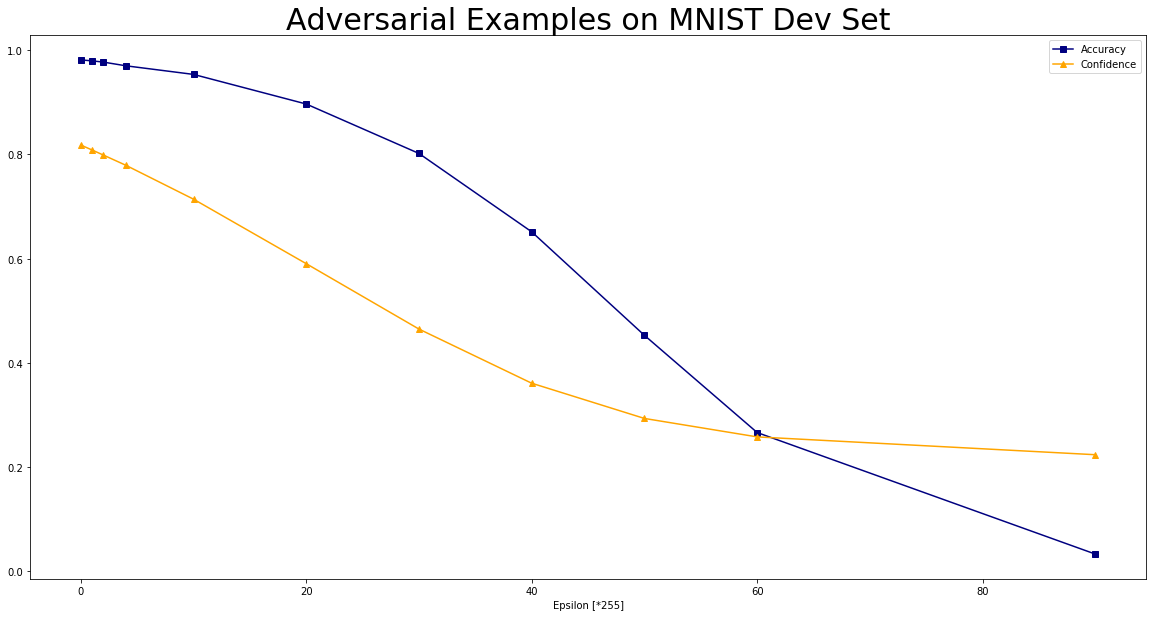

In [15]:
plt.plot(e, accuracy_adversarial, "s-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on MNIST Dev Set", fontsize=30)
plt.legend()
#plt.show()

plt.savefig("Adversarial_Examples_MNIST_FGSM.pdf")
plt.savefig("Adversarial_Examples_MNIST_FGSM.png")

## 4.2 Some iterative method

In the previous section we found examples which are classified as the wrong class at a high confidence using the FGSM. To the human eye however, these examples can clearly be distinguished from the clean examples. Another problem with FGSM is that ist can be used for untargeted attacks only.

In [ ]:
## Implement

## 5. Conclusions

Fast gradient sign method produces examples which can be detected by a human.

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*
